### Hedging a short call option with shares

In [1]:
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def BlackScholesMerton(S, K, r, sigma, T, q=0):
    '''
    Returns BSM prices of EU call and put options as well as intermediate results
    T in years = time to maturity
    q = dividends yield
    '''
    d1 = ((math.log(S/K) + (r + 0.5*sigma**2)*T))/(sigma*math.sqrt(T))
    d2 = ((math.log(S/K) + (r - 0.5*sigma**2)*T))/(sigma*math.sqrt(T))
    N1 = norm.cdf(d1) # = delta
    N2 = norm.cdf(d2)
    C = S*math.exp(-q*T)*N1 - K*math.exp(-r*T)*N2 # call price
    P = C + K*math.exp(-r*T) - S # put price
    
    return C, P, N1, N2, d1, d2

In [3]:
#testing BlackScholesMerton()
S = 100
K = 100
r = 0.05
sigma = 0.25
T = 0.25
C, P, N1, N2, d1, d2 = BlackScholesMerton(S, K, r, sigma, T)
print("C =", C, "\nP =", P, "\nN1 =", N1, "\nN2 =", N2, "\nd1 =", d1, "\nd2 =", d2)

C = 5.598400241450669 
P = 4.356180290838807 
N1 = 0.5645439358620384 
N2 = 0.5149568299259097 
d1 = 0.1625 
d2 = 0.037500000000000006


In [5]:
# prices history over 20 days
prices = [55.5625,
         55.3750,
         55.4375,
         56.5625,
         59.1250,
         60.3125,
         61.3125,
         60.6250,
         62.6875,
         61.25,
         63.25,
         64.1875,
         64.25,
         65,
         63,
         64.1875,
         65.8125,
         68.25,
         68.125,
         68.8125]

df = pd.DataFrame({"t": range(len(prices)), "S(t)": prices})

Short a call option => rrisk = variation of underlying price, for a EU call we have $$\Delta_C=\frac{\partial C(t,S)}{\partial S} = N(d_1)$$
which is equal to the number of shares (by replication of a call option price with a self-financing portfolio)

In [6]:
'''
option parameters
'''
# Black-Scholes parameters

T0 = 20 # days
n_periods = 252 # days
K = 55
r = 0.0 # annualized
sigma = 0.317139
premium = 1.0

def call_price(row, K, r, sigma):
    return BlackScholesMerton(row['S(t)'], K, r, sigma, row['T'])[0]
def delta(row, K, r, sigma):
    return BlackScholesMerton(row['S(t)'], K, r, sigma, row['T'])[2]

df['T'] = df['t'].map(lambda x:(T0-x)/n_periods)

df['C(t,S(t))'] = df.apply(call_price, K=K, r=r, sigma=sigma, axis=1) # = S(t)
df['Delta'] = df.apply(delta, K=K, r=r, sigma=sigma, axis=1) # = N(d_1)

t=0 : 
- sell option at $C(0)$, buy $\Delta(0)$ shares
- initial portfolio: $X(0) = C(0)$  

t=1 : 
- update shares portfolio $X(1) = X(0) + \Delta(0)(S(1) - S(0))$
- update option price to $\Delta(1)$ => buy or sell shares to replicate (borrow from or transfer to bank account)

In [7]:
'''
shares account
'''
# at t=0 buy Delta(0) shares
initial_value = df.loc[0, 'Delta']*df.loc[0, 'S(t)']
shares = [initial_value]*len(df)
# at t>=1, update shares account to: Delta(t)*price(t)
for i in range(1, len(df)):
    shares[i] = df.loc[i, 'Delta']*df.loc[i, 'S(t)']
    # borrow from borrow_account to buy more shares
    # or pay back if selling   
df['shares_account'] = shares

'''
borrow account
'''
# at t=0, borrow: Delta(0)*S(0) - profit from selling call
call_selling_price = df.loc[0, 'C(t,S(t))']*premium
initial_borrow = df.loc[0, 'Delta']*df.loc[0, 'S(t)'] - call_selling_price
borrow_account = [initial_borrow]*len(df)
# at t>=1, update borrow account
for i in range(1, len(df)):
    # growth of previous balance
    borrow_account[i] = borrow_account[i-1]*math.exp(r/n_periods)
    # add (Delta(t) - Delta(t-1))*S(t)
    # >0 if borrowing to buy shares, <0 if paying back by selling shares
    borrow_account[i] += (df.loc[i, 'Delta'] - df.loc[i-1, 'Delta'])*df.loc[i, 'S(t)']
df['borrow_account'] = borrow_account

'''
replicating portfolio
'''
# replicating portfolio = amount in shares - amount borrowed
df['option replication'] = df['shares_account'] - df['borrow_account']
# P&L = replicating portfolio - Call payoff
df['PnL w/ hedging'] = df['option replication'] - df['C(t,S(t))']
# P/L without hedging = initial call price - payoff
df['PnL w/o hedging'] = df.loc[0, 'C(t,S(t))'] - df['C(t,S(t))']

In [8]:
df

,t,S(t),T,"C(t,S(t))",Delta,shares_account,borrow_account,option replication,PnL w/ hedging,PnL w/o hedging
0,0,55.5625,0.079365,2.263737,0.562993,31.281288,29.017551,2.263737,0.000000,0.000000
1,1,55.3750,0.075397,2.109965,0.548381,30.366589,28.208412,2.158176,0.048211,0.153773
2,2,55.4375,0.071429,2.093499,0.554033,30.714200,28.521750,2.192450,0.098951,0.170239
3,3,56.5625,0.067460,2.718667,0.648498,36.680690,33.864953,2.815737,0.097070,-0.454930
4,4,59.1250,0.063492,4.578253,0.827662,48.935494,44.457980,4.477514,-0.100739,-2.314516
5,5,60.3125,0.059524,5.566673,0.890723,53.721727,48.261365,5.460362,-0.106311,-3.302936
6,6,61.3125,0.055556,6.453747,0.932004,57.143520,50.792435,6.351085,-0.102662,-4.190010
7,7,60.6250,0.051587,5.794358,0.917408,55.617876,49.907543,5.710332,-0.084026,-3.530621
8,8,62.6875,0.047619,7.733527,0.972888,60.987928,53.385441,7.602487,-0.131040,-5.469789
9,9,61.2500,0.043651,6.334334,0.951293,58.266681,52.062721,6.203960,-0.130373,-4.070596


<Axes: title={'center': 'PnL'}>

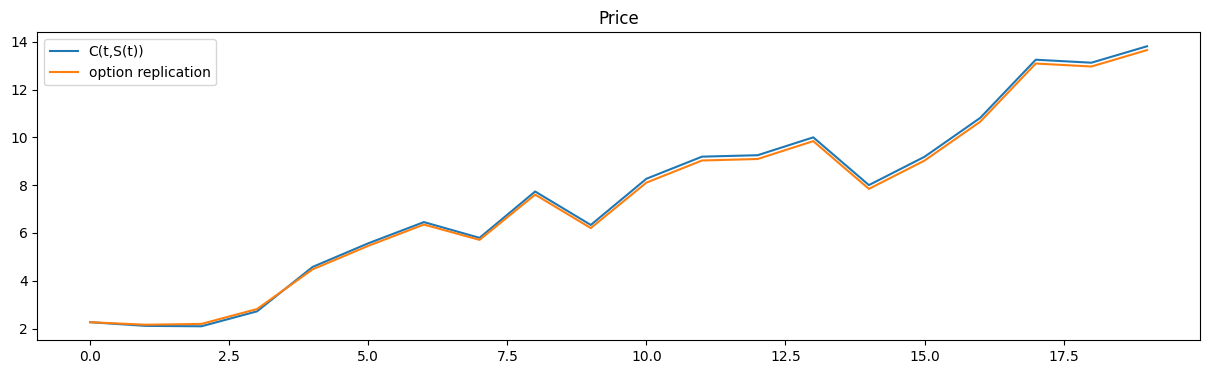

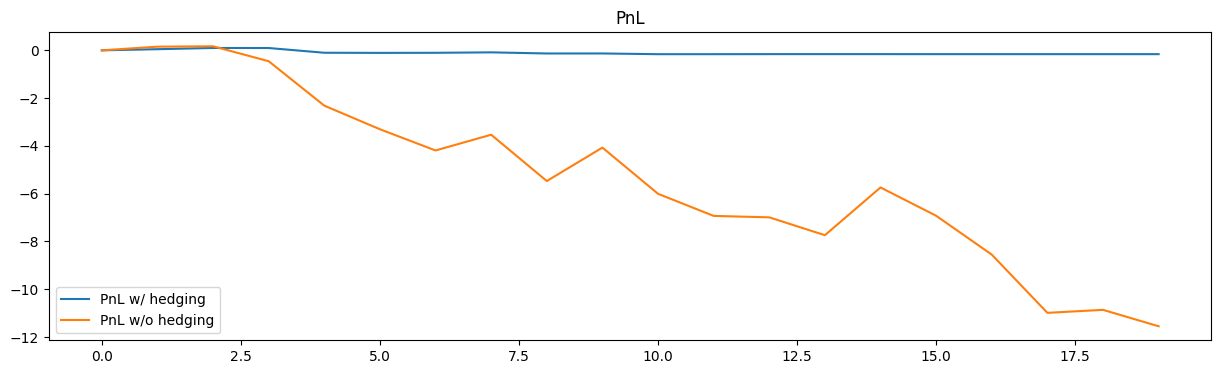

In [9]:
#fig,ax = plt.subplots(figsize=(15,4))
df[['C(t,S(t))', 'option replication']].plot(title='Price', figsize=(15,4))
df[['PnL w/ hedging', 'PnL w/o hedging']].plot(title='PnL', figsize=(15,4))